In [46]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LassoCV

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, top_k_accuracy_score, precision_score, recall_score, precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
import torch
from torch_geometric.data import HeteroData

import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from itertools import product
from copy import deepcopy

In [2]:
# Using GPU?
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
music = pd.read_csv("music.csv")
music.head()

,artist.hotttnesss,artist.id,artist.name,artist_mbtags,artist_mbtags_count,bars_confidence,bars_start,beats_confidence,beats_start,duration,...,start_of_fade_out,tatums_confidence,tatums_start,tempo,terms,terms_freq,time_signature,time_signature_confidence,title,year
0,0.401998,ARD7TVE1187B99BFB1,Casual,NaN,0.0,0.643,0.58521,0.834,0.58521,218.93179,...,218.932,0.779,0.28519,92.198,hip hop,1.000000,4.0,0.778,I Didn't Mean To,0
1,0.417500,ARMJAGH1187FB546F3,The Box Tops,classic pop and rock,1.0,0.007,0.71054,1.000,0.20627,148.03546,...,137.915,0.969,0.20627,121.274,blue-eyed soul,1.000000,4.0,0.384,Soul Deep,1969
2,0.343428,ARKRRTF1187B9984DA,Sonora Santanera,NaN,0.0,0.980,0.73152,0.980,0.73152,177.47546,...,172.304,0.482,0.42132,100.070,salsa,1.000000,1.0,0.000,Amor De Cabaret,0
3,0.454231,AR7G5I41187FB4CE6C,Adam Ant,uk,1.0,0.017,1.30621,0.809,0.81002,233.40363,...,217.124,0.601,0.56254,119.293,pop rock,0.988584,4.0,0.000,Something Girls,1982
4,0.401724,ARXR32B1187FB57099,Gob,NaN,0.0,0.175,1.06368,0.883,0.13576,209.60608,...,198.699,1.000,0.13576,129.738,pop punk,0.887288,4.0,0.562,Face the Ashes,2007


### Feature Selection

Drop all artists and release related columns. Keep song features and genre.

In [16]:
select_cols = ['bars_confidence', 'bars_start', 'beats_confidence', 'beats_start', 'duration', 'end_of_fade_in', 'key', 'key_confidence', 'loudness',
               'mode', 'mode_confidence', 'start_of_fade_out', 'tatums_confidence', 'tatums_start', 'tempo', 'time_signature', 'time_signature_confidence', 'terms']

music = music[select_cols]

print(music.shape[0])
music.info()

10000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bars_confidence            10000 non-null  float64
 1   bars_start                 10000 non-null  float64
 2   beats_confidence           10000 non-null  float64
 3   beats_start                10000 non-null  float64
 4   duration                   10000 non-null  float64
 5   end_of_fade_in             10000 non-null  float64
 6   key                        10000 non-null  float64
 7   key_confidence             10000 non-null  float64
 8   loudness                   10000 non-null  float64
 9   mode                       10000 non-null  int64  
 10  mode_confidence            10000 non-null  float64
 11  start_of_fade_out          10000 non-null  float64
 12  tatums_confidence          10000 non-null  float64
 13  tatums_start               10000 non-null

### Data Cleaning

In [17]:
print(music[music.isna().any(axis=1)].shape[0])
music[music.isna().any(axis=1)].head(5)

5


,bars_confidence,bars_start,beats_confidence,beats_start,duration,end_of_fade_in,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tatums_confidence,tatums_start,tempo,time_signature,time_signature_confidence,terms
752,0.306,1.59658,0.872,0.39238,230.29506,0.289,1.0,0.515,-5.614,0,0.237,221.304,0.737,0.39238,100.173,4.0,0.531,NaN
1004,0.103,0.09522,0.000,0.09522,206.57587,0.000,11.0,0.546,-14.440,0,0.751,191.199,0.374,0.09522,122.041,3.0,0.656,NaN
2835,0.586,0.36694,0.495,0.36694,235.38893,0.000,11.0,0.000,-19.488,0,0.076,228.095,0.999,0.36694,85.508,3.0,1.000,NaN
2950,0.159,0.75800,0.673,0.75800,238.52363,0.000,2.0,0.625,-19.938,1,0.742,229.866,0.503,0.38939,80.003,4.0,0.000,NaN
9158,0.018,1.20669,0.785,0.44904,186.22649,2.194,4.0,0.596,-5.105,1,0.602,175.607,0.627,0.25288,155.726,4.0,0.000,NaN


In [18]:
music = music.dropna()
music[music.isna().any(axis=1)]
print(music.shape[0])
music.describe()

9995


,bars_confidence,bars_start,beats_confidence,beats_start,duration,end_of_fade_in,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tatums_confidence,tatums_start,tempo,time_signature,time_signature_confidence
count,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000
mean,0.239597,1.065377,0.613988,0.428506,240.632653,0.756838,5.366363,0.451455,-10.482312,0.691146,0.477763,229.893776,0.507805,0.299886,122.908022,3.564425,0.599866
std,0.288297,1.723846,0.322446,0.806404,246.144775,1.859315,9.673712,0.332186,5.398842,0.462044,0.191217,112.050304,0.332391,0.511047,35.206683,1.266889,8.993811
min,0.000000,0.000000,0.000000,-60.000000,1.044440,0.000000,0.000000,0.000000,-51.643000,0.000000,0.000000,-21.394000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.035000,0.441685,0.409500,0.194650,175.999550,0.000000,2.000000,0.225000,-13.159000,0.000000,0.360000,168.855000,0.237000,0.110675,96.964500,3.000000,0.098000
50%,0.120000,0.785640,0.686000,0.332480,223.059140,0.199000,5.000000,0.469000,-9.379000,1.000000,0.487000,213.850000,0.500000,0.191490,120.160000,4.000000,0.551000
75%,0.351000,1.224150,0.882000,0.500755,276.375060,0.421000,8.000000,0.659000,-6.532000,1.000000,0.606000,266.292000,0.774500,0.294685,144.008500,4.000000,0.864000
max,8.855240,59.743540,1.000000,12.245830,22050.000000,43.119000,904.802810,19.081000,0.566000,1.000000,1.000000,1813.426000,9.227560,12.245830,262.828000,7.000000,898.891000


In [19]:
music.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9995 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bars_confidence            9995 non-null   float64
 1   bars_start                 9995 non-null   float64
 2   beats_confidence           9995 non-null   float64
 3   beats_start                9995 non-null   float64
 4   duration                   9995 non-null   float64
 5   end_of_fade_in             9995 non-null   float64
 6   key                        9995 non-null   float64
 7   key_confidence             9995 non-null   float64
 8   loudness                   9995 non-null   float64
 9   mode                       9995 non-null   int64  
 10  mode_confidence            9995 non-null   float64
 11  start_of_fade_out          9995 non-null   float64
 12  tatums_confidence          9995 non-null   float64
 13  tatums_start               9995 non-null   float64
 1

### Manually delete Tag

In [20]:
unique_tag = music['terms'].astype(str).unique()
print(unique_tag.shape[0])
def mapping(map_dict, genre_list, map_into):
    for genre in genre_list:
        map_dict[genre] = map_into
    return map_dict

458


In [21]:
hip_hop = [
    'hip hop', 'rap', 'gangster rap', 'pop rap', 'dirty rap', 'underground rap', 'alternative hip hop', 'east coast hip hop', 'hardcore hip hop', 'hip house', 
    'dirty south rap', 'rap metal', 'old school hip hop', 'alternative rap', 'miami bass', 'crunk', 'hyphy', 'jazz rap', 'hip pop', 'electro hip hop'
]

pop = [
    'pop rock', 'dance pop', 'power pop', 'british pop', 'freestyle', 'teen pop', 'indie pop', 'synthpop', 'electropop', 'bubblegum pop', 'brill building pop', 
    'pop', 'pop folk', 'j pop', 'electroclash', 'europop', 'instrumental pop', 'dance-punk', 'boy band', 'bubblegum dance', 'german pop'
]

rock = [
    'alternative rock', 'blues-rock', 'new wave', 'noise rock', 'gothic rock', 'glam rock', 'modern rock', 'southern rock', 'suomi rock', 'indie rock', 
    'shoegaze', 'grunge', 'art rock', 'classic rock', 'hard rock', 'psychedelic rock', 'progressive rock', 'garage rock', 'punk blues', 'stoner rock', 'math rock', 
    'post rock', 'trip rock', 'soft rock', 'dance rock', 'post-grunge', 'folk rock', 'heartland rock', 'alternative pop rock', 'kraut rock', 'surf music', 'glam metal', 
    'southern soul', 'garage punk', 'deathrock', 'shock rock', "rock 'n roll", 'celtic rock', 'neo-progressive', 'instrumental rock', 'punk', 'noise pop', 
    'protopunk', 'industrial rock', 'visual kei', 'freakbeat', 'rockabilly', 'symphonic rock', 'piano rock', 'glam', 'merseybeat', 'jam band', 'space rock', 
    'pinoy rock', 'rock', 'rap rock', 'swamp rock', 'electro rock'
]

jazz = [
    'jazz fusion', 'new orleans jazz', 'cool jazz', 'hard bop', 'bebop', 'free jazz', 'big band', 'acid jazz', 'swing', 'chamber jazz', 'gypsy jazz', 'jazz funk', 
    'brazilian jazz', 'latin jazz', 'jazz blues', 'vocal jazz', 'smooth jazz', 'nu jazz', 'jazz'
]

metal = [
    'gothic metal', 'death core', 'groove metal', 'melodic metalcore', 'viking metal', 'stoner metal', 'thrash core', 'death metal', 'industrial metal', 'doom metal', 
    'power metal', 'black metal', 'symphonic metal', 'alternative metal', 'heavy metal', 'nu metal', 'hardcore metal', 'grindcore', 'blackened death metal', 'melodic death metal', 
    'avantgarde metal', 'digital hardcore', 'ambient black metal', 'sympho black metal', 'sludge metal', 'funeral doom', 'progressive metal', 'speed metal', 'goregrind', 
    'brutal death metal', 'technical death metal', 'folk metal'
]

electronic = [
    'speedcore', 'electronic', 'breakbeat', 'breakcore', 'trip hop', 'house', 'techno', 'trance', 'dubstep', 'tech house', 'vocal house', 'big beat', 
    'broken beat', 'dark ambient', 'power electronics', 'alternative dance', 'hard trance', 'dark wave', 'new beat', 'neue deutsche welle', 'disco house', 
    'detroit techno', 'goa', 'vocal trance', 'hardstyle', 'deep house', 'funky house', 'progressive house', 'hard house', 'gabba', 'drum and bass', 
    'electro', 'eurodance', 'industrial dance', 'bass music', 'downtempo', '8-bit', 'jungle music', 'chicago house', 'ghetto tech', 'progressive trance', 'chill-out', 
    'indietronica', 'uk garage', 'electronica', 'hardcore techno', 'grime', 'happy hardcore', 'glitch', 'future jazz', 'ragga jungle', 'italian disco', 
    'tribal house', 'melodic trance', 'dubtronica', 'speed garage'
]

rnb_soul = [
    'doo-wop', 'blue-eyed soul', 'new jack swing', 'nu-soul', 'quiet storm', 'neo soul', 'soul jazz', 'funk', 'disco', 'chicago soul', 'motown', 
    'northern soul', 'r&b', 'soul', 'g-funk', 'soul music'
]

folk = [
    'polka', 'chanson', 'bluegrass', 'folk-pop', 'irish folk', 'neo-folk', 'celtic', 'americana', 'roots rock', 'folk', 'filk', 'slack key guitar', 
    'urban folk', 'jug band', 'progressive bluegrass', 'chanson francaise', 'folktronica', 'folk rock', 'irish', 'singer-songwriter', 'outlaw country', 
    'jangle pop', 'country folk', 'manouche', 'new romantic', 'french pop', 'twee pop', 'ballad', 'space age pop', 'dream pop', 'chamber pop', 'oldies', 
    'swamp pop', 'lounge music', 'neofolk'
]

country = [
    'country rock', 'classic country', 'western swing', 'country blues', 'honky tonk', 'outlaw country', 'country', 'alternative country', 'country music'
]

reggae = [
    'roots reggae', 'dancehall', 'rock steady', 'dub', 'reggae', 'lovers rock'
]

gospel = [
    'gospel', 'southern gospel', 'christian rock', 'christian metal', 'christian hardcore', 'ccm', 'country gospel', 'religious music', 'christian music'
]

classical = [
    'opera', 'symphony', 'requiem', 'chamber music', 'classical', 'sonata', 'concerto', 'early music', 'neoclassical', 'contemporary classical music', 
    'orchestra', 'ballet', 'Russian Easter Festival_ Overture_ Op.36'
]

blues = [
    'blues', 'zydeco', 'electric blues', 'chicago blues', 'delta blues', 'texas blues', 'jump blues', 'piedmont blues', 'harmonica blues', 
    'soul blues', 'swamp blues', 'new orleans blues', 'east coast blues', 'louisiana blues', 'memphis blues', 'piano blues', 'classic female blues'
]

latin = [
    'latin', 'salsa', 'charanga', 'rumba', 'samba', 'boogaloo', 'merengue', 'musica', 'bachata', 'flamenco', 'bossa nova', 'mambo', 'mariachi', 
    'tango', 'cumbia', 'latin pop', 'latin jazz', 'bolero', 'ranchera', 'tejano', 'brazilian pop music', 'argentine rock', 'bel canto', 'reggaeton'
]

experimental = [
    'experimental', 'experimental rock', 'experimental pop', 'avant-garde', 'noise pop', 'free music', 'illbient'
]

world = [
    'world', 'qawwali', 'arabesque', 'chinese music', 'bhangra', 'exotica', 'rebetika', 'klezmer', 'celtic fusion', 'world fusion', 'kizomba', 'zouk', 
    'gaita', 'soukous', 'highlife', 'afrobeat', 'ska', 'frevo', 'world music', 'world beat', 'island music', 'congo', 'choro', 'cantonese pop', 'mandarin pop', 
    'british blues', 'massachusetts', 'british invasion', 'zouklove'
]

punk = [
    'punk', 'math-core', 'hardcore punk', 'pop punk', 'rapcore', 'skate punk', 'horror punk', 'celtic punk', 'garage punk', 'dance-punk', 'post-hardcore', 
    'ska punk', 'oi', 'screamo', 'emo', 'synth punk', 'queercore', 'riot grrrl', 'folk punk', 'christian punk', 'melodic hardcore', 'power violence'
]

soundtrack_misc = [
    'soundtrack', 'video game music', 'show tunes', 'cabaret', 'vaudeville', 'musette', 'balada', 'easy listening', 'meditation', 'new age', 'relaxation', 
    'space music', 'lo-fi', 'ost', 'lullaby', 'chant'
]

comedy = [
    'comedy', 'parody', 'stand-up comedy', 'comedy rock', 'funny', 'comedy rap'
]

other = [
    'los angeles', 'california', 'san francisco bay area', 'united states', 'german', 'vocal', 'turntablism', 'gothic', 'dance music', 'singer-songwriter', 
    'male vocalist', 'female vocalist', 'guitar', 'guitarist', 'dj', 'chorus', 'club', 'serialism', 'alternative', 'indie', 'urban', 'straight edge', 
    'sxsw 2007', 'beat', 'protopunk', 'marrabenta', 'banda', 'vallenato', 'modern laika', 'patriotic', 'peace punk', 'close harmony', 'fusion', 
    'all-female', 'slow core', 'rare groove', 'chalga', 'sadcore', 'game', 'kirtan', 'batucada', 'mondiovision', 'no wave', 'melbourne', 'manouche', 
    'bulerias', 'calypso', 'funk rock', 'funk metal', 'psychobilly', 'marimba', 'ragtime', 'free improvisation', 'humppa', 'brazil', 'greek', 'turnablism', 'ethnic', 
    'japanese', 'mexico', 'canadian', 'swedish', 'swiss', 'spanish', 'finish', 'desi'
]

mapping_dict = {}
parent_genre_str = ['hip hop', 'pop', 'rock', 'jazz', 'metal', 'electronic', 'r&b/soul', 'folk', 'country', 'reggae', 'gospel', 'classical', 'blues', 'latin', 'experimental', 'world', 'punk', 'soundtrack/misc', 'commedy', 'other']
parent_genre = [hip_hop, pop, rock, jazz, metal, electronic, rnb_soul, folk, country, reggae, gospel, classical, blues, latin, experimental, world, punk, soundtrack_misc, comedy, other]

for i in range(len(parent_genre)):
    mapping_dict = mapping(mapping_dict, parent_genre[i], parent_genre_str[i])
music['terms'] = music['terms'].astype(str)
music['genre'] = music['terms'].map(mapping_dict)
music['genre']

0        hip hop
1       r&b/soul
2          latin
3            pop
4           punk
          ...   
9995       metal
9996        folk
9997      reggae
9998       blues
9999      gospel
Name: genre, Length: 9995, dtype: object

In [22]:
filtered = music.loc[music['terms'].notna() & music['genre'].isna()]
print(filtered['terms'].unique())

[]


In [23]:
# def list_genres_per_release(X, y, genre_names=None):
#     df = X.copy()
#     df['genre'] = y

#     df = df.dropna(subset=['release.id'])

#     grouped = df.groupby('release.id')['genre'].apply(set)

#     if genre_names:
#         grouped = grouped.apply(lambda genre_set: {genre_names[g] for g in genre_set})

#     return grouped

In [24]:
# X = music.drop(columns=['terms', 'genre'])
# y = music['genre'].astype('category').cat.codes

# release_genres = list_genres_per_release(X, y)

# print(release_genres.head(100))

In [26]:
# encode terms to numeric
label_encoder = LabelEncoder()
music['genre_encoded'] = label_encoder.fit_transform(music['genre'])

X = music.drop(columns=['genre', 'genre_encoded'])
y = music['genre_encoded']

class_names = [str(c) for c in label_encoder.classes_]

index_to_genre = dict(enumerate(label_encoder.classes_))
print(index_to_genre)

# all features
features = X.columns.tolist()
print(f"Features", features)

{0: 'blues', 1: 'classical', 2: 'commedy', 3: 'country', 4: 'electronic', 5: 'experimental', 6: 'folk', 7: 'gospel', 8: 'hip hop', 9: 'jazz', 10: 'latin', 11: 'metal', 12: 'other', 13: 'pop', 14: 'punk', 15: 'r&b/soul', 16: 'reggae', 17: 'rock', 18: 'soundtrack/misc', 19: 'world'}
Features ['bars_confidence', 'bars_start', 'beats_confidence', 'beats_start', 'duration', 'end_of_fade_in', 'key', 'key_confidence', 'loudness', 'mode', 'mode_confidence', 'start_of_fade_out', 'tatums_confidence', 'tatums_start', 'tempo', 'time_signature', 'time_signature_confidence', 'terms']


In [27]:
# Total number of unique genres
num_classes = len(np.unique(y))

num_classes

20

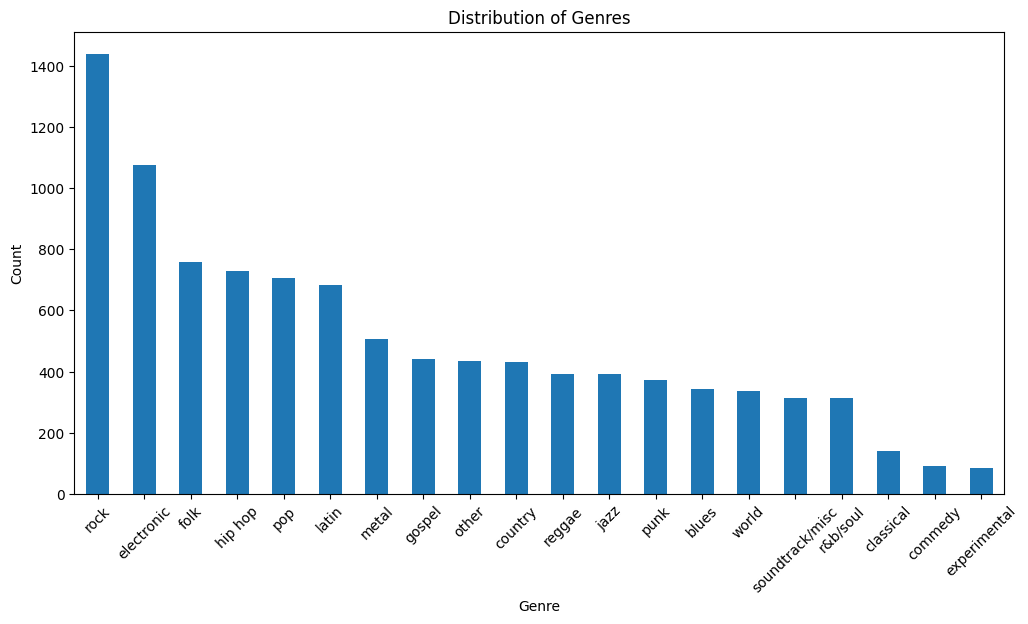

In [28]:
# Histogram of the target variable
plt.figure(figsize=(12, 6))
music['genre'].value_counts().plot(kind='bar')
plt.title('Distribution of Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Generate Train - Validate - Test Dataset

In [29]:
music.head(5)

,bars_confidence,bars_start,beats_confidence,beats_start,duration,end_of_fade_in,key,key_confidence,loudness,mode,mode_confidence,start_of_fade_out,tatums_confidence,tatums_start,tempo,time_signature,time_signature_confidence,terms,genre,genre_encoded
0,0.643,0.58521,0.834,0.58521,218.93179,0.247,1.0,0.736,-11.197,0,0.636,218.932,0.779,0.28519,92.198,4.0,0.778,hip hop,hip hop,8
1,0.007,0.71054,1.000,0.20627,148.03546,0.148,6.0,0.169,-9.843,0,0.430,137.915,0.969,0.20627,121.274,4.0,0.384,blue-eyed soul,r&b/soul,15
2,0.980,0.73152,0.980,0.73152,177.47546,0.282,8.0,0.643,-9.689,1,0.565,172.304,0.482,0.42132,100.070,1.0,0.000,salsa,latin,10
3,0.017,1.30621,0.809,0.81002,233.40363,0.000,0.0,0.751,-9.013,1,0.749,217.124,0.601,0.56254,119.293,4.0,0.000,pop rock,pop,13
4,0.175,1.06368,0.883,0.13576,209.60608,0.066,2.0,0.092,-4.501,1,0.371,198.699,1.000,0.13576,129.738,4.0,0.562,pop punk,punk,14


Uncomment if needed

In [ ]:
# dataset = music.drop(columns=['terms'])

# # train - validation - test: 80-10-10
# train_val_data, test_data = train_test_split(dataset, test_size=0.1, random_state=40)
# train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=40)

# train_data.to_csv('train_data.csv', index=False)
# val_data.to_csv('val_data.csv', index=False)
# test_data.to_csv('test_data.csv', index=False)

In [54]:
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")
val_data = pd.read_csv("val_data.csv")

X_train, y_train = train_data.drop(columns=['genre_encoded', 'genre']), train_data['genre_encoded']
X_test, y_test = test_data.drop(columns=['genre_encoded', 'genre']), test_data['genre_encoded']
X_val, y_val = val_data.drop(columns=['genre_encoded', 'genre']), val_data['genre_encoded']

### Logistic Regression (Baseline)

In [55]:
transformer = StandardScaler().fit(X_train)
X_train_norm = pd.DataFrame(transformer.transform(X_train), columns = X_train.columns)

# Apply the same transformation to the testing set
X_test_norm = transformer.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, columns=X_test.columns)

log_reg = LogisticRegression(random_state=0, max_iter=1000).fit(X_train_norm, y_train)
log_reg.predict_proba(X_test_norm)

array([[0.01790918, 0.01410819, 0.00604988, ..., 0.14796468, 0.03733866,
        0.03369505],
       [0.00839556, 0.00047337, 0.0062739 , ..., 0.12976756, 0.00531959,
        0.04689635],
       [0.04362625, 0.00497515, 0.00679729, ..., 0.12325968, 0.04482659,
        0.04074099],
       ...,
       [0.03500067, 0.01021401, 0.00904931, ..., 0.14286127, 0.04131195,
        0.03280558],
       [0.02150581, 0.00246711, 0.00871665, ..., 0.1658376 , 0.01222924,
        0.0410867 ],
       [0.01399063, 0.05939828, 0.00883411, ..., 0.05128692, 0.19948446,
        0.0194018 ]])

---

In [56]:
# Make predictions
y_pred = log_reg.predict(X_test_norm)
y_proba = log_reg.predict_proba(X_test_norm)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.1690
Precision: 0.0972
Recall: 0.0996
F1 Score: 0.0859


In [57]:

# Top-k accuracy
top1 = top_k_accuracy_score(y_test, y_proba, k=1)  # Same as regular accuracy
top2 = top_k_accuracy_score(y_test, y_proba, k=2)


print(f"Top-1 Accuracy (regular): {top1:.4f}")
print(f"Top-2 Accuracy: {top2:.4f}")


Top-1 Accuracy (regular): 0.1690
Top-2 Accuracy: 0.3080


In [58]:
# Step 7: Print detailed classification report
print("Logistic Regression (Per-Class Report)")
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

Logistic Regression (Per-Class Report)
                 precision    recall  f1-score   support

          blues       0.11      0.03      0.05        33
      classical       0.00      0.00      0.00        23
        commedy       0.00      0.00      0.00         6
        country       0.11      0.16      0.13        38
     electronic       0.21      0.32      0.25       110
   experimental       0.00      0.00      0.00         7
           folk       0.14      0.07      0.09        85
         gospel       0.00      0.00      0.00        53
        hip hop       0.21      0.29      0.25        73
           jazz       0.19      0.12      0.15        34
          latin       0.14      0.02      0.03        65
          metal       0.18      0.10      0.13        48
          other       0.00      0.00      0.00        47
            pop       0.00      0.00      0.00        71
           punk       0.39      0.27      0.32        44
       r&b/soul       0.00      0.00      0.00  

Accuracy: 0.169


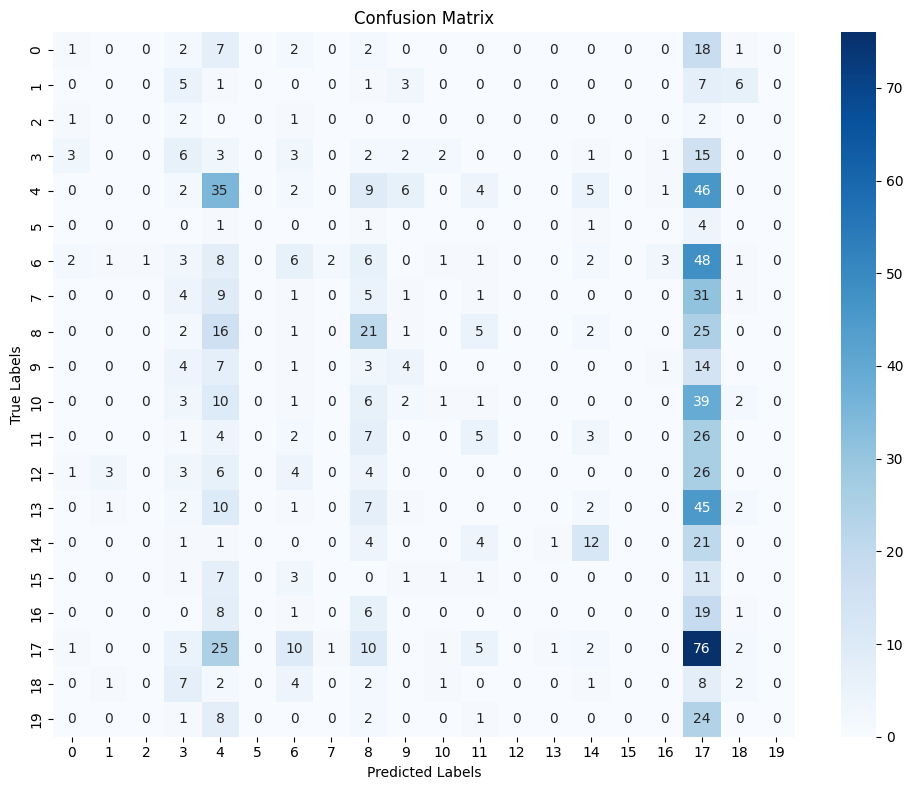

Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.03      0.05        33
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00         6
           3       0.11      0.16      0.13        38
           4       0.21      0.32      0.25       110
           5       0.00      0.00      0.00         7
           6       0.14      0.07      0.09        85
           7       0.00      0.00      0.00        53
           8       0.21      0.29      0.25        73
           9       0.19      0.12      0.15        34
          10       0.14      0.02      0.03        65
          11       0.18      0.10      0.13        48
          12       0.00      0.00      0.00        47
          13       0.00      0.00      0.00        71
          14       0.39      0.27      0.32        44
          15       0.00      0.00      0.00        25
          16       0.00      0.00      0.00        35
    

In [59]:
y_pred = log_reg.predict(X_test_norm)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

class_report = classification_report(y_test, y_pred, zero_division=0)
print("Classification Report:")
print(class_report)


#### Graph Neural Networks

##### Graph Structure

<div>
<img src="media/graph.jpg" width="500"/>
</div>

In [25]:
# These will be the three key identifiers
song_id_map = {sid: i for i, sid in enumerate(list(music['song.id']))}                  # There can only be one song
artist_id_map = {aid: i for i, aid in enumerate(list(music['artist.id'].unique()))}     # They can be under the same artist

In [26]:
all_genres = music['genre'].unique().tolist()

genre_to_idx = {g: i for i, g in enumerate(all_genres)}
num_genres = len(all_genres)

In [27]:
# SONG NODE

song_features = [
    'bars_confidence', 'bars_start', 'beats_confidence', 'beats_start',
    'duration', 'end_of_fade_in', 'key', 'key_confidence', 'loudness',
    'mode', 'mode_confidence', 'start_of_fade_out', 'tatums_confidence',
    'tatums_start', 'tempo', 'time_signature', 'time_signature_confidence'
]

num_songs = len(music)
num_song_feats = len(song_features)
song_x = np.zeros((num_songs, num_song_feats), dtype=np.float32)

song_y_list = []

for i, (idx, row) in enumerate(music.iterrows()):
    song_x[i] = row[song_features].values

    genre_str = row['genre']
    label_idx = genre_to_idx[genre_str]
    song_y_list.append(label_idx)

song_x = torch.tensor(song_x, dtype=torch.float32)
song_y = torch.tensor(song_y_list, dtype=torch.long)


In [28]:
### ARTIST NODE ###
artist_features = ['artist.hotttnesss', 'artist_mbtags_count', 'familiarity']
artist_ids = music['artist.id'].unique()
num_artists = len(artist_ids)
artist_x = np.zeros((num_artists, len(artist_features)), dtype=np.float32)

for i, aid in enumerate(artist_ids):
    rows = music[music['artist.id'] == aid].iloc[0]
    artist_x[i] = rows[artist_features].values

artist_x = torch.tensor(artist_x, dtype=torch.float32)

In [29]:
## BUILD EDGES ###

# First row is source idx (artist)
# Second row is the destination (song)

# Artist --> Song

artist_src = []
song_dst = []

for idx, row in music.iterrows():
    s_id = row['song.id']
    a_id = row['artist.id']
    s_idx = song_id_map[s_id]
    a_idx = artist_id_map[a_id]

    artist_src.append(a_idx)
    song_dst.append(s_idx)

artist_song_edge_index = torch.tensor([artist_src, song_dst], dtype=torch.long)


In [30]:
data = HeteroData()

data['song'].x = song_x
data['song'].y = song_y
data['artist'].x = artist_x

# Artist -> Song
data[('artist', 'creates', 'song')].edge_index = artist_song_edge_index

# Bidirectional,so flipped
data[('song', 'rev_creates', 'artist')].edge_index = data[('artist', 'creates', 'song')].edge_index.flip(0)

metadata = data.metadata()

print(data)
print(f'\n\n{metadata}')


HeteroData(
  song={
    x=[9989, 17],
    y=[9989],
  },
  artist={ x=[3880, 3] },
  (artist, creates, song)={ edge_index=[2, 9989] },
  (song, rev_creates, artist)={ edge_index=[2, 9989] }
)


(['song', 'artist'], [('artist', 'creates', 'song'), ('song', 'rev_creates', 'artist')])


In [31]:
num_songs = data['song'].x.size(0)

indices = np.arange(num_songs)
np.random.shuffle(indices)

train_size = int(0.7 * num_songs)
val_size   = int(0.15 * num_songs)
test_size  = num_songs - train_size - val_size

train_idx = indices[:train_size]
val_idx   = indices[train_size:train_size+val_size]
test_idx  = indices[train_size+val_size:]

train_mask = torch.zeros(num_songs, dtype=torch.bool)
val_mask   = torch.zeros(num_songs, dtype=torch.bool)
test_mask  = torch.zeros(num_songs, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx]     = True
test_mask[test_idx]   = True

data['song'].train_mask = train_mask
data['song'].val_mask   = val_mask
data['song'].test_mask  = test_mask

In [32]:
hom_data = data.clone().to_homogeneous()
scaler = StandardScaler()
hom_data.x = torch.tensor(scaler.fit_transform(hom_data.x.cpu().numpy()), dtype=torch.float32).to(device)

hom_data=hom_data.to(device)


In [34]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.batch_norm1 = torch.nn.BatchNorm1d(hidden_channels)
        self.batch_norm2 = torch.nn.BatchNorm1d(hidden_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv3(x, edge_index)
        return x
    
def train():
    model.train()
    optimizer.zero_grad()
    out = model(hom_data.x, hom_data.edge_index)
    loss = F.cross_entropy(out[hom_data.train_mask], hom_data.y[hom_data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate(mask):
    model.eval()
    out = model(hom_data.x, hom_data.edge_index)
    pred = out[mask].argmax(dim=-1)
    correct = (pred == hom_data.y[mask]).sum()
    acc = int(correct) / int(mask.sum())
    return acc
    
in_channels = hom_data.num_features
hidden_channels = 64
out_channels = hom_data.y.max().item() + 1
dropout = 0.5

model = GCN(in_channels, hidden_channels, out_channels, dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

epochs = 100
best_val_acc = 0
best_model_state = None
patience = 10
patience_counter = 0
train_losses = []
val_accs = []
test_accs = []

model.to(device)
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    #check device of each tensor
    out = model(hom_data.x, hom_data.edge_index)
    loss = criterion(out[hom_data.train_mask], hom_data.y[hom_data.train_mask])
    loss.backward()
    optimizer.step()
    train_loss = loss.item()
    train_losses.append(train_loss)
    
    train_acc = evaluate(hom_data.train_mask)
    val_acc = evaluate(hom_data.val_mask)
    test_acc = evaluate(hom_data.test_mask)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    
    print(f"Epoch: {epoch:03d}, Loss: {train_loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    final_test_acc = evaluate(hom_data.test_mask)
    print(f"Final test accuracy: {final_test_acc:.4f}")

Epoch: 001, Loss: 3.4222, Train: 0.0912, Val: 0.0748, Test: 0.0967
Epoch: 002, Loss: 3.1813, Train: 0.1429, Val: 0.1389, Test: 0.1534
Epoch: 003, Loss: 3.0252, Train: 0.1766, Val: 0.1649, Test: 0.1821
Epoch: 004, Loss: 2.8964, Train: 0.1934, Val: 0.1669, Test: 0.1881
Epoch: 005, Loss: 2.8215, Train: 0.2025, Val: 0.1722, Test: 0.1868
Epoch: 006, Loss: 2.7743, Train: 0.2052, Val: 0.1822, Test: 0.1901
Epoch: 007, Loss: 2.7190, Train: 0.2102, Val: 0.1936, Test: 0.1948
Epoch: 008, Loss: 2.6848, Train: 0.2180, Val: 0.2043, Test: 0.2048
Epoch: 009, Loss: 2.6665, Train: 0.2235, Val: 0.2130, Test: 0.2075
Epoch: 010, Loss: 2.6498, Train: 0.2308, Val: 0.2256, Test: 0.2128
Epoch: 011, Loss: 2.6310, Train: 0.2343, Val: 0.2290, Test: 0.2168
Epoch: 012, Loss: 2.5968, Train: 0.2346, Val: 0.2270, Test: 0.2221
Epoch: 013, Loss: 2.5881, Train: 0.2367, Val: 0.2310, Test: 0.2262
Epoch: 014, Loss: 2.5693, Train: 0.2416, Val: 0.2323, Test: 0.2328
Epoch: 015, Loss: 2.5682, Train: 0.2447, Val: 0.2363, Test: 0.

In [35]:
@torch.no_grad()
def top_k_accuracy(mask, k=3):
    model.eval()
    out = model(hom_data.x, hom_data.edge_index)
    true = hom_data.y[mask].cpu()
    topk = out[mask].topk(k, dim=-1).indices.cpu()  # (num_samples, k)
    correct = topk.eq(true.unsqueeze(1)).any(dim=1)  # Check if true label is in top-k
    return correct.float().mean().item()

print("Top 1 Accuracy:", evaluate(hom_data.test_mask))
print("Top 2 Accuracy:", top_k_accuracy(hom_data.test_mask, k=2))


Top 1 Accuracy: 0.25283522348232157
Top 2 Accuracy: 0.39959973096847534


In [ ]:
@torch.no_grad()
def gcn_classification_report(mask, class_names):
    model.eval()
    out = model(hom_data.x, hom_data.edge_index)
    pred = out[mask].argmax(dim=-1).cpu().numpy()
    true = hom_data.y[mask].cpu().numpy()
    print("GCN")
    print(classification_report(true, pred, target_names=class_names))

gcn_classification_report(hom_data.test_mask, class_names)

=== GCN ===
                 precision    recall  f1-score   support

          blues       0.32      0.45      0.37       113
      classical       0.00      0.00      0.00        36
        commedy       0.33      0.14      0.20       104
        country       0.00      0.00      0.00       106
     electronic       0.37      0.45      0.41        49
   experimental       0.29      0.06      0.10        68
           folk       0.24      0.49      0.32       149
         gospel       0.23      0.50      0.32       214
        hip hop       0.17      0.27      0.21       107
           jazz       0.30      0.33      0.32        72
          latin       0.00      0.00      0.00        50
          metal       0.58      0.10      0.17        68
          other       0.20      0.23      0.21        22
            pop       0.14      0.06      0.08        52
           punk       0.30      0.26      0.28        77
       r&b/soul       0.24      0.20      0.22        64
         reggae   

/user/lehoang2/cvl/project/genre-classification-404/cse404_proj/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/user/lehoang2/cvl/project/genre-classification-404/cse404_proj/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/user/lehoang2/cvl/project/genre-classification-404/cse404_proj/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

In [37]:


@torch.no_grad()
def evaluate(mask):
    model.eval()
    out = model(hom_data.x, hom_data.edge_index)
    probs = F.softmax(out[mask], dim=-1)
    preds = probs.argmax(dim=-1)
    y_true = hom_data.y[mask]

    # Top-1 accuracy
    top1_acc = (preds == y_true).float().mean().item()

    # Top-2 accuracy
    top2 = probs.topk(2, dim=-1).indices
    top2_acc = (top2[:, 0] == y_true) | (top2[:, 1] == y_true)
    top2_acc = top2_acc.float().mean().item()

    # Precision, recall, F1 (macro)
    y_true_np = y_true.cpu().numpy()
    preds_np = preds.cpu().numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true_np, preds_np, average='macro', zero_division=0
    )

    return {
        'top1_acc': top1_acc,
        'top2_acc': top2_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [ ]:
# Define the search space
param_grid = {
    'hidden_channels': [32, 64, 128],
    'dropout': [0.3, 0.5, 0.7],
    'lr': [0.01, 0.005],
    'weight_decay': [5e-4, 1e-3]
}

# Results storage
results = []

# Grid search
for hidden_channels, dropout, lr, weight_decay in product(*param_grid.values()):
    # print(f"\n>>> Trying: hidden={hidden_channels}, dropout={dropout}, lr={lr}, wd={weight_decay}")

    model = GCN(in_channels, hidden_channels, out_channels, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    best_val_acc = 0
    best_model_state = None
    patience_counter = 0
    patience = 10
    epochs = 100

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(hom_data.x, hom_data.edge_index)
        loss = criterion(out[hom_data.train_mask], hom_data.y[hom_data.train_mask])
        loss.backward()
        optimizer.step()

        val_metrics = evaluate(hom_data.val_mask)
        val_acc = val_metrics['top1_acc']

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                # print(f"Early stopping at epoch {epoch}")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)
        test_metrics = evaluate(hom_data.test_mask)

        run_result = {
            'hidden_channels': hidden_channels,
            'dropout': dropout,
            'lr': lr,
            'weight_decay': weight_decay,
            'val_acc': best_val_acc,
            **test_metrics,
            'model_state': deepcopy(best_model_state)
        }

        results.append(run_result)


# Final Best Config
results.sort(key=lambda r: r['val_acc'], reverse=True)
best = results[0]

print("\nBest Config + Test Performance")
for k, v in best.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")


=== Best Config + Test Performance ===
hidden_channels: 128
dropout: 0.3000
lr: 0.0100
weight_decay: 0.0005
val_acc: 0.4239
top1_acc: 0.4216
top2_acc: 0.5824
precision: 0.4654
recall: 0.3679
f1: 0.3848
model_state: OrderedDict([('conv1.bias', tensor([ 1.6253e-05, -3.5706e-05,  3.1460e-06,  3.9175e-05, -1.8190e-05,
         2.5928e-05,  5.1582e-05,  2.2559e-05,  1.7354e-05,  1.9873e-05,
        -5.6851e-05, -2.9037e-05,  7.6211e-06,  6.3609e-06,  5.1170e-06,
        -1.1739e-05, -2.6512e-05,  6.0923e-06, -1.1348e-05, -3.2082e-05,
        -1.7742e-05, -2.3875e-06, -1.7383e-06,  2.7264e-05, -1.6249e-06,
         3.8648e-05, -2.5231e-05,  3.9338e-05,  4.3906e-05, -2.0289e-05,
        -5.6882e-05,  3.3574e-06,  6.0069e-06,  9.3199e-06, -1.6419e-05,
        -5.5771e-05, -1.7135e-05, -4.1250e-05,  2.9478e-05,  2.8582e-05,
        -4.7887e-05,  4.5838e-05, -1.2989e-05, -1.1447e-05,  3.6523e-05,
         9.1354e-06,  2.5124e-05, -3.5988e-05, -3.5824e-05, -2.3856e-05,
        -2.5961e-05, -2.68

In [39]:
# Load the exact best state from the corresponding result
model = GCN(in_channels, best['hidden_channels'], out_channels, best['dropout']).to(device)
model.load_state_dict(best['model_state']) 
model.eval()


GCN(
  (conv1): GCNConv(17, 128)
  (conv2): GCNConv(128, 128)
  (conv3): GCNConv(128, 20)
  (batch_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [40]:

@torch.no_grad()
def get_predictions_and_labels(model, data, mask):
    out = model(data.x, data.edge_index)
    preds = out[mask].argmax(dim=-1).cpu().numpy()
    y_true = data.y[mask].cpu().numpy()
    return y_true, preds

# Use test mask
y_true, y_pred = get_predictions_and_labels(model, hom_data, hom_data.test_mask)

print(f"Top 1 Accuracy (recomputed): {accuracy_score(y_true, y_pred):.4f}")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


Top 1 Accuracy (recomputed): 0.4216
                 precision    recall  f1-score   support

          blues     0.4126    0.5221    0.4609       113
      classical     0.4000    0.1667    0.2353        36
        commedy     0.5738    0.3365    0.4242       104
        country     0.5167    0.2925    0.3735       106
     electronic     0.6222    0.5714    0.5957        49
   experimental     0.5273    0.4265    0.4715        68
           folk     0.4176    0.5101    0.4592       149
         gospel     0.3134    0.5888    0.4091       214
        hip hop     0.4000    0.2804    0.3297       107
           jazz     0.4634    0.5278    0.4935        72
          latin     0.3103    0.1800    0.2278        50
          metal     0.5818    0.4706    0.5203        68
          other     0.4000    0.3636    0.3810        22
            pop     0.2727    0.4038    0.3256        52
           punk     0.5238    0.4286    0.4714        77
       r&b/soul     0.5439    0.4844    0.5124     